In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:11 - loss: 0.0162 - STD: 7.3774e-05 - MAE: 0.0733

 2/64 [..............................] - ETA: 59s - loss: 0.0228 - STD: 2.4835e-04 - MAE: 0.1090 

 5/64 [=>............................] - ETA: 15s - loss: 0.0174 - STD: 4.7869e-04 - MAE: 0.0882

 8/64 [==>...........................] - ETA: 8s - loss: 0.0160 - STD: 8.4006e-04 - MAE: 0.0803 

11/64 [====>.........................] - ETA: 6s - loss: 0.0154 - STD: 0.0013 - MAE: 0.0845    

14/64 [=====>........................] - ETA: 4s - loss: 0.0148 - STD: 0.0016 - MAE: 0.0809

17/64 [======>.......................] - ETA: 3s - loss: 0.0145 - STD: 0.0020 - MAE: 0.0770

20/64 [========>.....................] - ETA: 3s - loss: 0.0141 - STD: 0.0025 - MAE: 0.0760

23/64 [=========>....................] - ETA: 2s - loss: 0.0139 - STD: 0.0031 - MAE: 0.0767

26/64 [===========>..................] - ETA: 2s - loss: 0.0135 - STD: 0.0038 - MAE: 0.0749

29/64 [============>.................] - ETA: 2s - loss: 0.0133 - STD: 0.0047 - MAE: 0.0730

32/64 [==============>...............] - ETA: 1s - loss: 0.0130 - STD: 0.0061 - MAE: 0.0724

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 0.0080 - MAE: 0.0715

38/64 [================>.............] - ETA: 1s - loss: 0.0123 - STD: 0.0105 - MAE: 0.0698

41/64 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 0.0141 - MAE: 0.0685

44/64 [===================>..........] - ETA: 0s - loss: 0.0114 - STD: 0.0183 - MAE: 0.0672

47/64 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 0.0228 - MAE: 0.0660

50/64 [======================>.......] - ETA: 0s - loss: 0.0106 - STD: 0.0267 - MAE: 0.0646

53/64 [=======================>......] - ETA: 0s - loss: 0.0102 - STD: 0.0297 - MAE: 0.0633

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.0327 - MAE: 0.0619

59/64 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.0360 - MAE: 0.0608

62/64 [============================>.] - ETA: 0s - loss: 0.0093 - STD: 0.0391 - MAE: 0.0597

64/64 [==============================] - 4s 51ms/step - loss: 0.0091 - STD: 0.0407 - MAE: 0.0589 - val_loss: 0.0049 - val_STD: 0.0685 - val_MAE: 0.0439


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0891 - MAE: 0.0370

 4/64 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0950 - MAE: 0.0363

 7/64 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0977 - MAE: 0.0363

10/64 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0982 - MAE: 0.0361

13/64 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0978 - MAE: 0.0359

16/64 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0983 - MAE: 0.0358

19/64 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0987 - MAE: 0.0356

22/64 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0984 - MAE: 0.0354

25/64 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0984 - MAE: 0.0353

28/64 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0351

31/64 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0350

34/64 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0349

37/64 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0347

40/64 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0346

43/64 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0344

46/64 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0343

49/64 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0342

52/64 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0992 - MAE: 0.0341

55/64 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0994 - MAE: 0.0339

58/64 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0994 - MAE: 0.0338

61/64 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0337

64/64 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0996 - MAE: 0.0335

64/64 [==============================] - 2s 27ms/step - loss: 0.0026 - STD: 0.0996 - MAE: 0.0335 - val_loss: 0.0026 - val_STD: 0.0853 - val_MAE: 0.0342


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.1010 - MAE: 0.0310

 4/64 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0306

 7/64 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0305

10/64 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0305

13/64 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0304

16/64 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0303

19/64 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0303

22/64 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0302

25/64 [==========>...................] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0302

28/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0302

31/64 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0302

34/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0301

37/64 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0301

40/64 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0300

43/64 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0299

46/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0300

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0298

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0298

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0297

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

64/64 [==============================] - 2s 27ms/step - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297 - val_loss: 0.0024 - val_STD: 0.0964 - val_MAE: 0.0332


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0289

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

10/64 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

13/64 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0289

16/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

19/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

22/64 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0288

28/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0287

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

43/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0285

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284 - val_loss: 0.0017 - val_STD: 0.0895 - val_MAE: 0.0294


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0313

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0294

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0291

10/64 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0295

13/64 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0294

16/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0293

19/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0293

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0293

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0293

28/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0294

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0294

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0293

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0292

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0291

43/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0290

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0287

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0287

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285 - val_loss: 0.0019 - val_STD: 0.0957 - val_MAE: 0.0297


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

 6/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

24/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

27/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0278

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274 - val_loss: 0.0018 - val_STD: 0.0963 - val_MAE: 0.0290


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0275

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

64/64 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273 - val_loss: 0.0019 - val_STD: 0.0966 - val_MAE: 0.0296


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0268

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0279

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0281

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0285

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0288

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0290

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0290

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0290

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0291

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0290

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0290

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0290

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0290

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0290 - val_loss: 0.0016 - val_STD: 0.0898 - val_MAE: 0.0284


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0278

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0280

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0278

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0274

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271 - val_loss: 0.0020 - val_STD: 0.0990 - val_MAE: 0.0303


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1096 - MAE: 0.0267

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0266

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266 - val_loss: 0.0017 - val_STD: 0.0963 - val_MAE: 0.0285


Epoch 11/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0262

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0261

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - 2s 26ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265 - val_loss: 0.0022 - val_STD: 0.1001 - val_MAE: 0.0326


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0280

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0269

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0269

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0269

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0269

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267 - val_loss: 0.0016 - val_STD: 0.0963 - val_MAE: 0.0281


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0264

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0265

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266 - val_loss: 0.0015 - val_STD: 0.0939 - val_MAE: 0.0275


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0270

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0273

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0273

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0272

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0272

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0272

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0271

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0983 - val_MAE: 0.0289


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0261

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

 6/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0265

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0271

14/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0271

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0271

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0271

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0272

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0271

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0271

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0271

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0271

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0271

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0271

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269 - val_loss: 0.0020 - val_STD: 0.0990 - val_MAE: 0.0303


Epoch 16/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1098 - MAE: 0.0269

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0263

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0263

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275 - val_loss: 0.0026 - val_STD: 0.1004 - val_MAE: 0.0349


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1130 - MAE: 0.0287

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0272

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0986 - val_MAE: 0.0290


Epoch 18/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0261

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0967 - val_MAE: 0.0280


Epoch 19/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0256

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0262

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0262

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0263

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0263

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0958 - val_MAE: 0.0276


Epoch 20/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0261

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0964 - val_MAE: 0.0277


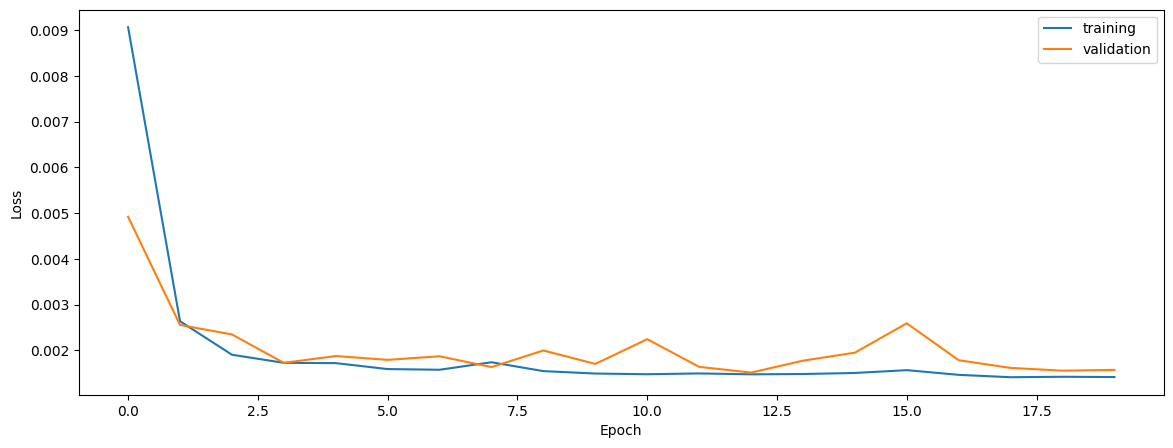

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9415731579847819
0.9539481537378842
0.9495541321952932


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9426526897606432
0.9515364570632631
0.9501968433267245


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9497612846921318
0.9537098349023815
0.9618182136275536


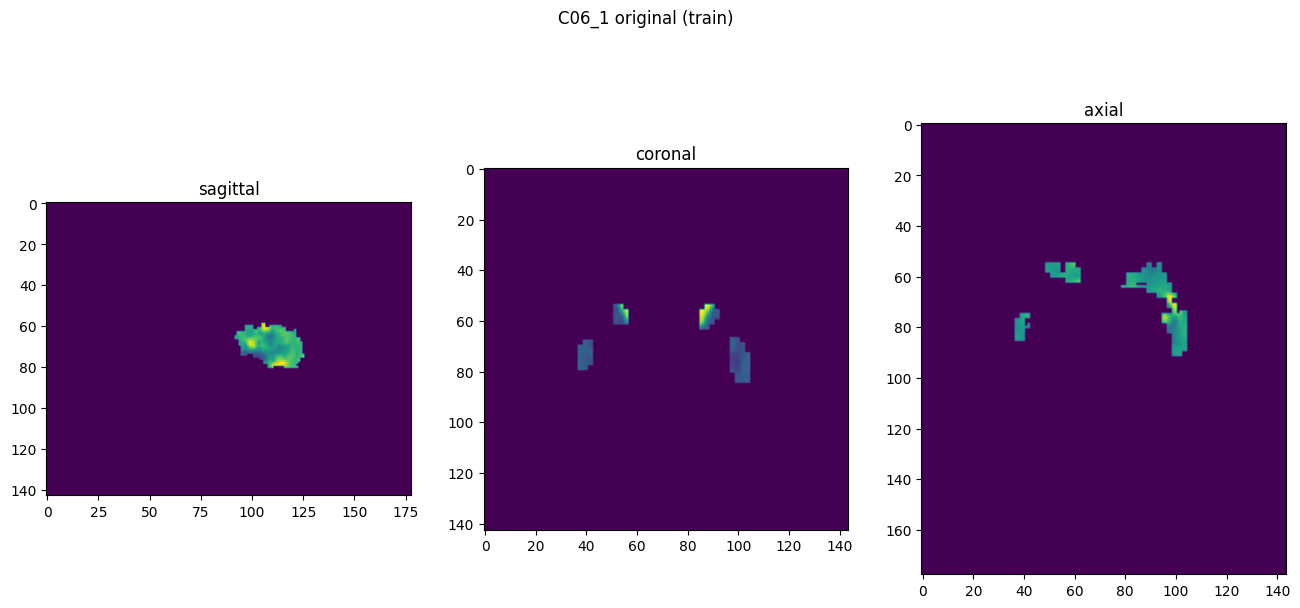

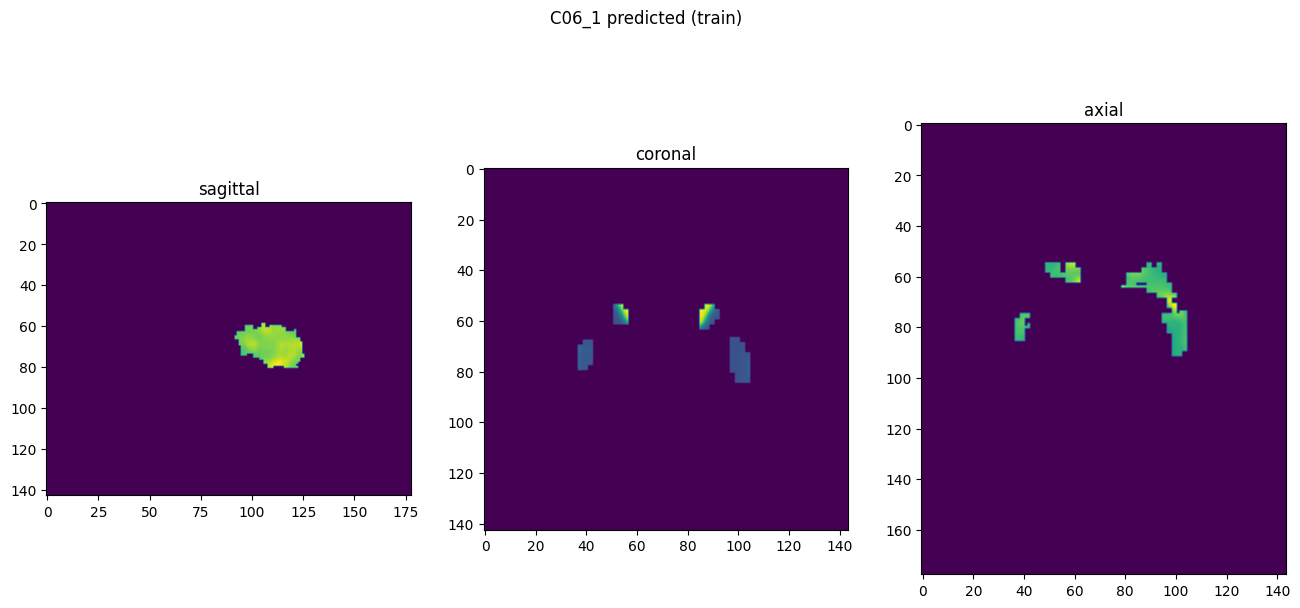

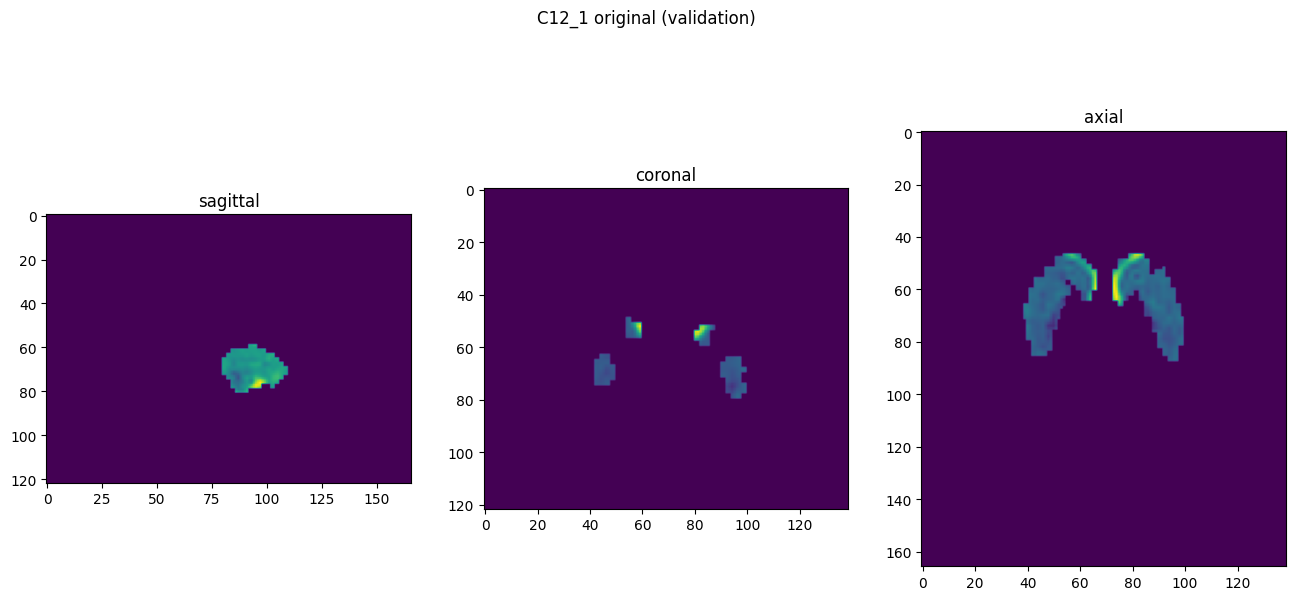

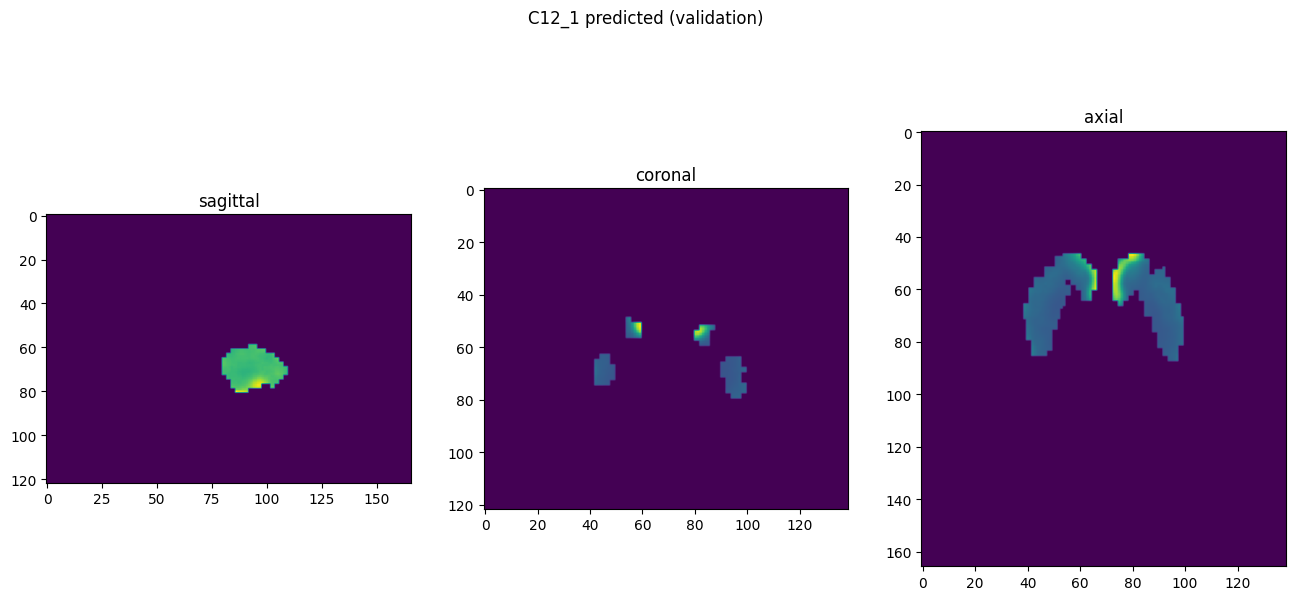

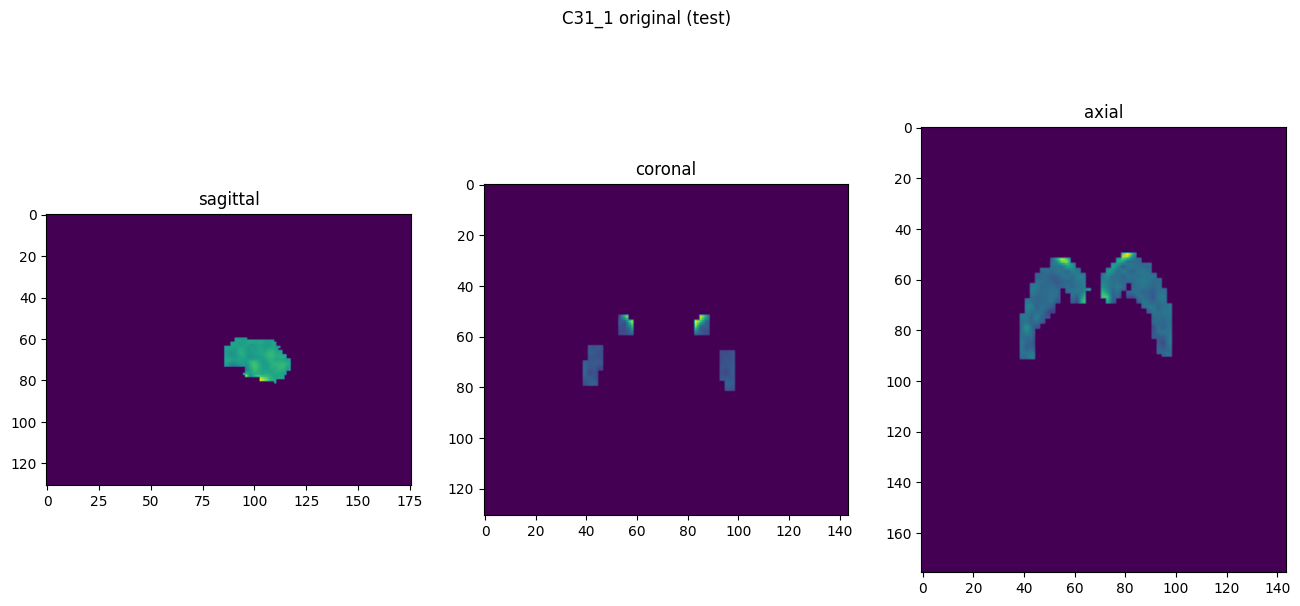

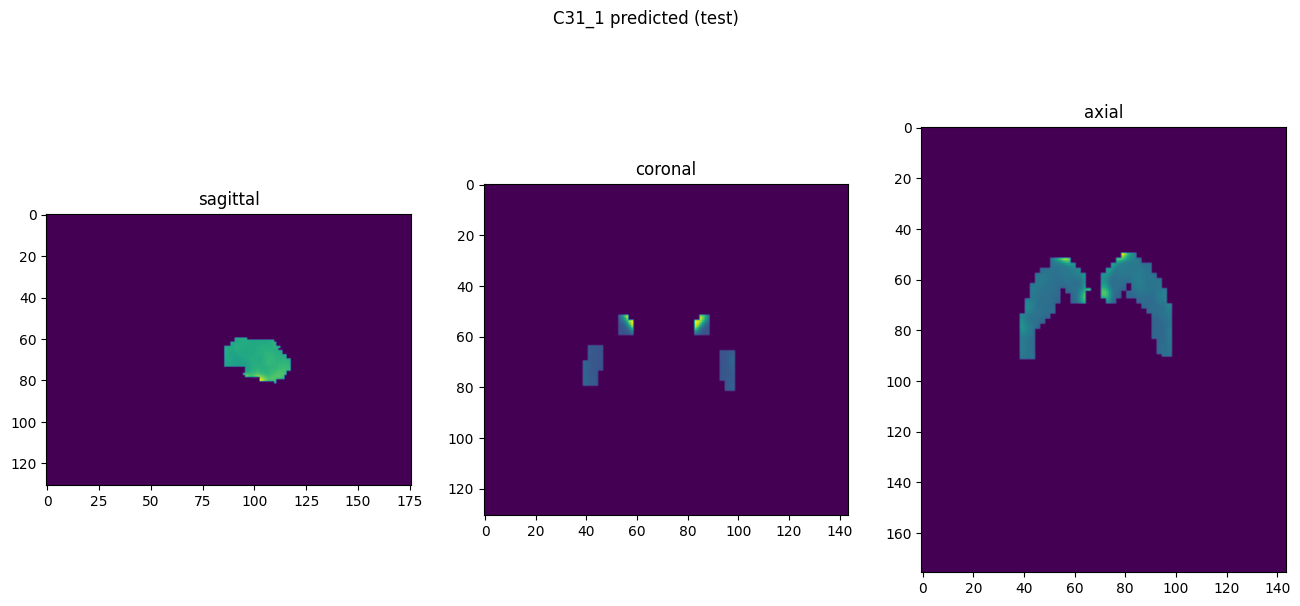

In [10]:
showResults(model, gen, threshold=None, background=False)